In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

PATH = "/home/koris/lunatech/testing/src/wav4"
files = []
file_count = 0
all = os.listdir(PATH)
all.sort()
for file in os.listdir(PATH):
    files.append(os.path.join(PATH, file))
files = np.array(files)
len(files)

24985

In [ ]:
import subprocess

if not os.path.exists("wav"):
  os.makedirs("wav")

i = 1
for file in files:
  base_name = os.path.basename(file)
  base_name = base_name.split('.')[0]
  p = subprocess.call(['ffmpeg', '-i', file,'wav/'+base_name +'.wav'])
  i += 1

In [ ]:
import subprocess

if not os.path.exists("wav4"):
    os.makedirs("wav4")

i = 1
for file in files:
    base_name = os.path.basename(file)
    base_name = base_name.split('.')[0]
    p = subprocess.call(['ffmpeg', '-i', file,'-t', '3', '-c', 'copy','wav4/'+base_name +'.wav'])
    i += 1
i

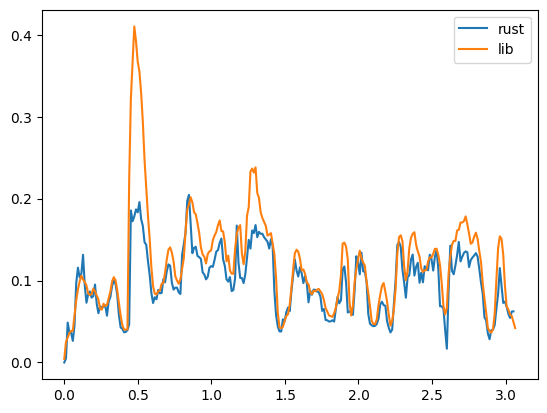

In [133]:
base_name = os.path.basename(files[0])
base_name = "/home/koris/lunatech/testing/src/wav4/000002.wav"

ifile = None
for kfile in files:
    if kfile == base_name:
        ifile = kfile

y, sr = librosa.load(ifile, sr=44100)
rms = librosa.feature.rms(y=y)
zcr = librosa.feature.zero_crossing_rate(y=y)

times = librosa.frames_to_time(np.arange(rms.shape[1])),
for time in times:
    time /= 2.0

spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)

lib_data = pd.DataFrame({
    'time': times[0],
    'rms': rms[0],
    'zcr': zcr[0],
    'spectral_centroid': spectral_centroid[0]
})

rust_dat = pd.read_csv('000002.wav.csv')
rust_dat = rust_dat[rust_dat['b_size'] == 1024]

plt.plot(rust_dat['time'], rust_dat['rms'], label='rust')
plt.plot(lib_data['time'], lib_data['rms'], label='lib')#
# add legend
plt.legend()

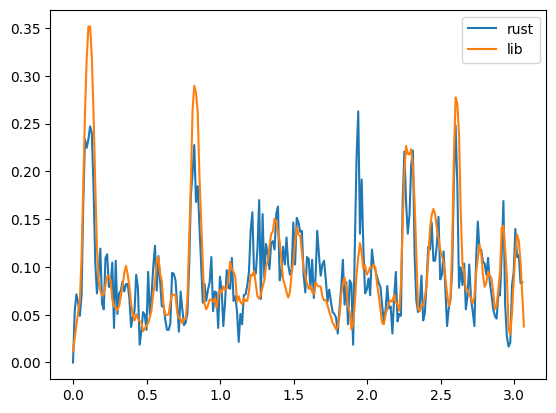

In [134]:
plt.plot(rust_dat['time'], rust_dat['zcr'], label='rust')
plt.plot(lib_data['time'], lib_data['zcr'], label='lib')
plt.legend()

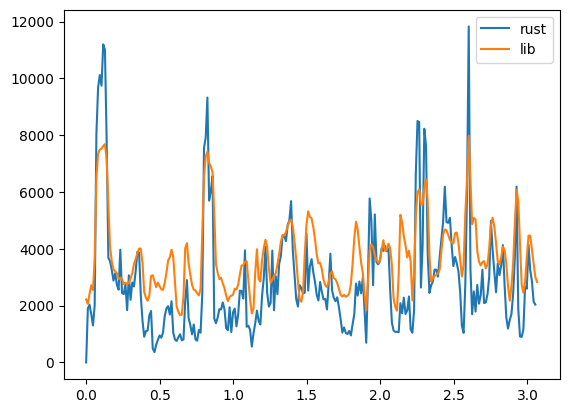

In [135]:
plt.plot(rust_dat['time'], rust_dat['spectral_centroid'], label='rust')
plt.plot(lib_data['time'], lib_data['spectral_centroid'], label='lib')
plt.legend()

In [ ]:
import pandas as pd

os.makedirs('librosa_wav_csvs', exist_ok=True)
for file in files:
    # create csv for file
    df = pd.DataFrame(columns=['time','rms','zcr','spectral_centroid'])
    y, sr = librosa.load(file, sr=44100)
    rms = librosa.feature.rms(y=y)
    zcr = librosa.feature.zero_crossing_rate(y)
    spectral_centroid = librosa.feature.spectral_centroid(y=y)
    times = librosa.frames_to_time(np.arange(rms.shape[1])),
    for time in times:
        time /= 2.0
    
    df['time'] = times[0]
    df['rms'] = rms[0]
    df['zcr'] = zcr[0]
    df['spectral_centroid'] = spectral_centroid[0]
    base_name = os.path.basename(file)

    df.to_csv('librosa_wav_csvs/' + base_name + '.csv')


In [136]:
# error between
lb_path = "librosa_wav_csvs/"
lt_path = "lt_wav_csv/"
new_dataframe = pd.DataFrame(columns=['name', 'b_size', 'rms', 'zcr', 'spectral_centroid', 'latency'])

for file in files:
    name = os.path.basename(file)
    if name == '097985.wav':
        continue
    # open file
    lb_df = pd.read_csv(lb_path + name + '.csv')
    lt_df = pd.read_csv(lt_path + name  + '.csv')

    # open new CSV file

    for b_size in lt_df.b_size.unique():
        name = name
        lt_df_b = lt_df[lt_df.b_size == b_size]
        lt_df_b_interp = lt_df_b.reindex(index=lb_df.time, method='nearest').interpolate(method='linear') 
        rms_dist = np.sqrt(np.mean(np.square(lt_df_b_interp.rms - lb_df.rms)))
        zcr_dist = np.sqrt(np.mean(np.square(lt_df_b_interp.zcr - lb_df.zcr)))
        spectral_centroid_dist = np.sqrt(np.mean(np.square(lt_df_b_interp.spectral_centroid - lb_df.spectral_centroid)))
        lt_avg_latency = lt_df_b_interp["latency"].mean()
        
        new_row = pd.DataFrame([[name, b_size, lt_avg_latency, rms_dist, zcr_dist, spectral_centroid_dist]], columns=['name', 'b_size', 'latency', 'rms', 'zcr', 'spectral_centroid'])
        new_dataframe = pd.concat([new_dataframe, new_row])

#new_dataframe
new_dataframe.to_csv('analysis.csv')
 

/tmp/ipykernel_221336/3283172450.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_dataframe = pd.concat([new_dataframe, new_row])


In [ ]:
analysis = pd.read_csv('analysis.csv')
analysis.head()


X = analysis[['rms', 'zcr', 'spectral_centroid', 'latency']]
y = analysis['b_size']

model = linear_model.LinearRegression()
model.fit(X, y)

print(model.coef_)

input_rms = 0.3
input_zcr = 0
input_spectral_centroid = 1000
input_latency = 15

input_df = pd.DataFrame([[input_rms, input_zcr, input_spectral_centroid, input_latency]], columns=['rms', 'zcr', 'spectral_centroid', 'latency'])

estimated_y = model.predict(input_df)
estimated_y

[ 5.55189887e+03  3.63836995e+03 -6.22796329e-02  1.31620904e+03]


array([22086.50983991])